# Analyse the classifier of PyFeat

In [18]:
from feat import Detector  # type: ignore
import cv2  # type: ignore
import os
import torch
import numpy as np
from feat.utils import FEAT_EMOTION_COLUMNS  # type: ignore
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

## Read the images & predict the emotions

In [7]:
if torch.backends.cudnn.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model="xgb",
    emotion_model="resmasknet",
    facepose_model="img2pose",
    device=device,
)

print(f"Using device: {device}")

Using device: mps


The images must be in the folder `./data/{emotion}` where `emotion` is the emotion of the images. The available emotions are `angry`, `happy`, `sad` and `neutral`.

In [15]:
emotions = ["angry", "happy", "sad", "neutral"]
pyfeat_emotions = ["anger", "happiness", "sadness", "neutral"]

true_labels = []
predicted_labels = []


def handle_file(file_path):
    frame = cv2.imread(file_path)

    detected_faces = detector.detect_faces(frame)
    detected_landmarks = detector.detect_landmarks(frame, detected_faces)
    detected_emotions = detector.detect_emotions(
        frame, detected_faces, detected_landmarks
    )[0]
    if len(detected_emotions) > 0:
        detected_emotion = FEAT_EMOTION_COLUMNS[np.argmax(detected_emotions[0])]
        if detected_emotion not in pyfeat_emotions:
            detected_emotion = "neutral"
        predicted_labels.append(detected_emotion)
        true_labels.append(pyfeat_emotion)


for i, emotion in enumerate(emotions):
    pyfeat_emotion = pyfeat_emotions[i]
    file_list = list(Path("data").glob(f"{emotion}/*.png")) + list(
        Path("data/kaggle").glob(f"{emotion}/*.jpg")
    )
    pbar = tqdm(file_list, desc=f"Processing {emotion}")
    for path in pbar:
        handle_file(path.as_posix())

# Save true_lablels list to file
with open("true_labels.txt", "w") as f:
    for item in true_labels:
        f.write("%s\n" % item)

# Save predicted_labels list to file
with open("predicted_labels.txt", "w") as f:
    for item in predicted_labels:
        f.write("%s\n" % item)

Processing angry:   0%|          | 0/1136 [00:00<?, ?it/s]/Users/tillgrutschus/Library/Caches/pypoetry/virtualenvs/botender-ccpriwyr-py3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing neutral: 100%|██████████| 1583/1583 [07:36<00:00,  3.46it/s]


## Evaluate the performance

Accuracy: 0.6478546579049091


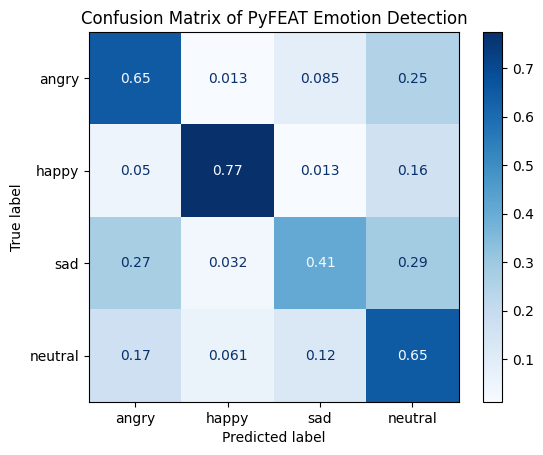

In [16]:
accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(
    true_labels
)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(
    np.array(true_labels),
    np.array(predicted_labels),
    normalize="true",
    labels=pyfeat_emotions,
)
dsp = ConfusionMatrixDisplay(cm, display_labels=emotions)
dsp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of PyFEAT Emotion Detection")
plt.show()

In [20]:
print(
    classification_report(true_labels, predicted_labels, target_names=pyfeat_emotions)
)

              precision    recall  f1-score   support

       anger       0.51      0.65      0.57       956
   happiness       0.92      0.77      0.84      1844
     sadness       0.52      0.65      0.58      1397
     neutral       0.59      0.41      0.48       977

    accuracy                           0.65      5174
   macro avg       0.64      0.62      0.62      5174
weighted avg       0.67      0.65      0.65      5174

